## 1. Introduction

Understanding user mobility behavior is an important aspect of spatio-temporal data analysis. 
One effective way to quantify how users move across different locations is through **location entropy**.

Location entropy measures the diversity of a user’s movement by examining how frequently they visit different locations. 
A higher entropy value indicates more diverse movement patterns, while a lower value suggests routine or localized behavior.

The objective of this analysis is to calculate location entropy for each user in a real-world mobility dataset, 
extract meaningful insights, and propose potential product ideas based on these insights.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

## 2. Dataset Description

The dataset used in this analysis is a publicly available spatio-temporal mobility dataset from the 
EPFL Mobility project (Crawdad repository).

Each record represents a user (cab) observed at a specific geographic location at a given time.
This dataset provides a realistic representation of mobility behavior in an urban environment
and is suitable for entropy-based movement analysis. Each line in the dataset contains the following attributes: latitude, longitude, occupancy, time.


In [ ]:
with open("_cabs.txt", "r") as f:
    content = f.read()

# count number of cabs
cab_ids_from_index = re.findall(r'id="([^"]+)"', content)

print("Number of cabs listed in _cabs.txt:", len(cab_ids_from_index))


Number of cabs listed in _cabs.txt: 536


In [ ]:
DATA_FOLDER = "cab_data/*.txt"  
# read all files
all_files = glob.glob(DATA_FOLDER)
dataframes = []

for file in all_files:
    cab_id = os.path.splitext(os.path.basename(file))[0]

    df = pd.read_csv(
        file,
        sep=" ",
        names=["latitude", "longitude", "occupancy", "timestamp"]
    )
    # add cab_id column
    df["cab_id"] = cab_id
    dataframes.append(df)
# combine to single master dataframe
df = pd.concat(dataframes, ignore_index=True)

print("Loaded cabs:", df["cab_id"].nunique())
print("Total GPS points:", len(df))
df.head()


Loaded cabs: 536
Total GPS points: 11219955


,latitude,longitude,occupancy,timestamp,cab_id
0,37.75134,-122.39488,0,1213084687,new_abboip
1,37.75136,-122.39527,0,1213084659,new_abboip
2,37.75199,-122.39460,0,1213084540,new_abboip
3,37.75080,-122.39346,0,1213084489,new_abboip
4,37.75015,-122.39256,0,1213084237,new_abboip


In [ ]:
# check missing values per column
df.isnull().sum()
# remove any rows with missing value
df = df.dropna()
df = df.reset_index(drop=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11219955 entries, 0 to 11219954
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   latitude     float64
 1   longitude    float64
 2   occupancy    int64  
 3   timestamp    int64  
 4   cab_id       object 
 5   location_id  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 513.6+ MB


## 3. Methodology

### 3.1 Location Definition
A location is defined as a discretized spatial point derived from unique latitude–longitude
coordinate pairs. Each unique coordinate pair is treated as a distinct location visited by a user.

### 3.2 Probability Estimation
For each user, the probability of being at a specific location is calculated as the fraction of
visits to that location relative to the total number of visits made by the user.

### 3.3 Location Entropy
Location entropy is computed using Shannon entropy


In [38]:
GRID_SIZE = 0.01  # ~1km grid

# Vectorized binning (100x faster than .apply)
# We calculate the grid indices directly on the whole column array
df['lat_bin'] = np.floor(df['latitude'] / GRID_SIZE).astype(int)
df['lon_bin'] = np.floor(df['longitude'] / GRID_SIZE).astype(int)

# Create location_id by combining the bins
df['location_id'] = df['lat_bin'].astype(str) + '_' + df['lon_bin'].astype(str)

# Drop temporary columns to keep memory usage low
df.drop(columns=['lat_bin', 'lon_bin'], inplace=True)

df.head()

,latitude,longitude,occupancy,timestamp,cab_id,location_id
0,37.75134,-122.39488,0,1213084687,new_abboip,3775_-12240
1,37.75136,-122.39527,0,1213084659,new_abboip,3775_-12240
2,37.75199,-122.39460,0,1213084540,new_abboip,3775_-12240
3,37.75080,-122.39346,0,1213084489,new_abboip,3775_-12240
4,37.75015,-122.39256,0,1213084237,new_abboip,3775_-12240


In [39]:
def calculate_location_entropy(df, user_col="cab_id", location_col="location_id"):
    """
    Calculate location entropy per user using base-2 logarithm (bits).
    
    Formula: H = -sum(p(i) * log2(p(i)))
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input spatio-temporal dataset
    user_col : str
        Column representing user identifier
    location_col : str
        Column representing location identifier

    Returns
    -------
    pandas.DataFrame
        DataFrame with user ID and corresponding location entropy in bits.
    """

    if df.empty:
        raise ValueError("Input DataFrame is empty")

    # 1. Count visits per user per location
    # Use size() to count occurrences of each (user, location) pair
    visit_counts = (
        df.groupby([user_col, location_col])
        .size()
        .reset_index(name="visit_count")
    )

    # 2. Calculate Probability p(i)
    # Use transform('sum') to get the total visits for each user and broadcast it back
    total_visits = visit_counts.groupby(user_col)["visit_count"].transform("sum")
    visit_counts["p"] = visit_counts["visit_count"] / total_visits

    # 3. Calculate Entropy Component
    visit_counts["entropy_component"] = -visit_counts["p"] * np.log2(visit_counts["p"])

    # 4. Aggregate to get total entropy per user
    entropy_df = (
        visit_counts.groupby(user_col)["entropy_component"]
        .sum()
        .reset_index(name="location_entropy")
    )

    return entropy_df

In [40]:
entropy_df = calculate_location_entropy(
    df,
    user_col="cab_id",
    location_col="location_id"
)

entropy_df.head()


,cab_id,location_entropy
0,new_abboip,5.480898
1,new_abcoij,1.102795
2,new_abdremlu,6.365913
3,new_abgibo,5.986960
4,new_abjoolaw,5.835757


## 5. Results and Findings

The computed entropy values show clear differences in user mobility behavior.

- Users with **low entropy** tend to visit a small number of locations repeatedly,
  indicating routine and predictable movement patterns.
- Users with **high entropy** visit many locations more evenly, suggesting highly mobile behavior.
- Most users fall within a moderate entropy range, indicating semi-flexible mobility.


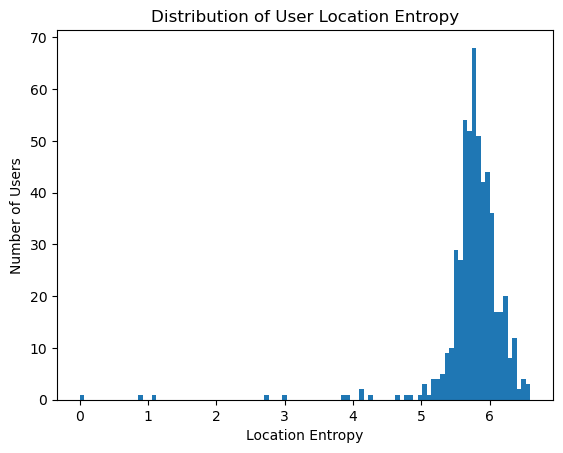

In [41]:
plt.hist(entropy_df["location_entropy"], bins=100)
plt.xlabel("Location Entropy")
plt.ylabel("Number of Users")
plt.title("Distribution of User Location Entropy")
plt.show()


## 6. Insights

### Insight 1: Mobility-Based Segmentation
Location entropy can be used to segment users into routine, semi-flexible, and highly mobile groups.

### Insight 2: Behavioral Change Detection
Significant changes in entropy over time may indicate abnormal behavior, operational changes,
or external events affecting user mobility.


## 7. Product Ideas

### Product Idea 1: Personalized Mobility Services
User segmentation based on location entropy can be used to personalize transport
recommendations and location-based services.

### Product Idea 2: Anomaly Detection
Sudden changes in entropy can serve as signals for detecting fraud, device sharing,
or abnormal operational behavior.

### Product Idea 3: Urban Planning
Aggregated entropy metrics can help city planners identify highly dynamic regions
and optimize transportation infrastructure.


## 8. Conclusion

This study demonstrates how location entropy can be used to quantify user mobility behavior
in spatio-temporal data. Beyond metric computation, the analysis emphasizes interpretability,
insight extraction, and real-world applicability.

Location entropy proves to be a valuable feature for mobility analysis,
user segmentation, and data-driven product development.
